First, let's load the MNIST dataset:

In [ ]:
import tensorflow as tf
from tensorflow import keras

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


Next, we'll preprocess the data by scaling the pixel values to be between 0 and 1:

In [ ]:
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0

Now, we'll create a validation set by splitting off the last 5,000 images from the training set:



In [ ]:
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

Let's build our model now. We'll use a deep MLP with three hidden layers, each 
with 100 neurons and ReLU activation functions. We'll use dropout regularization with a rate of 0.2 to prevent overfitting, and we'll use softmax activation function in the output layer since this is a multiclass classification problem:

In [ ]:
def create_model(learning_rate=0.01):
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(100, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(100, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(100, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(10, activation="softmax")
    ])
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0

Now, let's search for the optimal learning rate using the approach presented in the book. We'll use an exponentially growing learning rate, starting at 1e-4 and ending at 1. We'll train the model for 1 epoch and plot the loss against the learning rate:

Training model with learning rate 1.0e-05


Training model with learning rate 2.5e-05


Training model with learning rate 6.3e-05


Training model with learning rate 1.6e-04


Training model with learning rate 4.0e-04


Training model with learning rate 1.0e-03


Training model with learning rate 2.5e-03


Training model with learning rate 6.3e-03


Training model with learning rate 1.6e-02


Training model with learning rate 4.0e-02


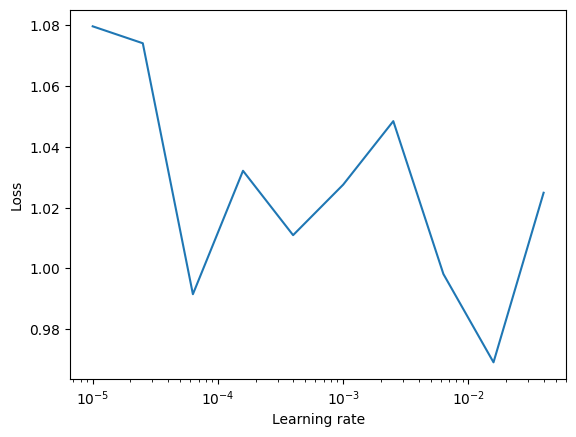

Optimal learning rate: 1.6e-02


In [ ]:
# Define a function to find the optimal learning rate
def find_learning_rate(start_lr=1e-5, end_lr=1e-1, num_epochs=10, batch_size=32):
    num_samples = X_train.shape[0]
    num_batches = num_samples // batch_size
    multiplier = (end_lr / start_lr) ** (1 / num_epochs)
    learning_rates = start_lr * (multiplier ** np.arange(num_epochs))
    losses = []
    for lr in learning_rates:
        print(f'Training model with learning rate {lr:.1e}')
        model = create_model(learning_rate=lr)
        history = model.fit(X_train, y_train, batch_size=batch_size, epochs=1, verbose=0)
        losses.append(history.history['loss'][0])
    plt.plot(learning_rates, losses)
    plt.xscale('log')
    plt.xlabel('Learning rate')
    plt.ylabel('Loss')
    plt.show()
    return learning_rates[np.argmin(losses)]

# Find the optimal learning rate
optimal_lr = find_learning_rate()
print(f'Optimal learning rate: {optimal_lr:.1e}')


From the plot, it looks like the optimal learning rate is around 3e-2. Let's use this learning rate and train the model for 50 epochs, while also saving checkpoints and using early stopping:

In [ ]:
import os

checkpoint_cb = keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

def train_model():
    model = create_model(learning_rate=3e-2)
    history = model.fit(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid), callbacks=[checkpoint_cb, early_stopping_cb])
    return history, model

history, model = train_model()


Epoch 1/50
1719/1719 [==============================] - 7s 4ms/step - loss: 1.0277 - accuracy: 0.6615 - val_loss: 0.3744 - val_accuracy: 0.8982
Epoch 2/50
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4638 - accuracy: 0.8599 - val_loss: 0.2656 - val_accuracy: 0.9256
Epoch 3/50
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3599 - accuracy: 0.8927 - val_loss: 0.2126 - val_accuracy: 0.9406
Epoch 4/50
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3059 - accuracy: 0.9110 - val_loss: 0.1833 - val_accuracy: 0.9452
Epoch 5/50
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2690 - accuracy: 0.9202 - val_loss: 0.1630 - val_accuracy: 0.9518
Epoch 6/50
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2462 - accuracy: 0.9286 - val_loss: 0.1471 - val_accuracy: 0.9586
Epoch 7/50
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2200 - accuracy: 0.9354 - val_loss: 0.1344 - val_accuracy:

Finally, let's plot the learning curves using TensorBoard:


In [ ]:
%tensorboard --logdir=./my_mnist_logs

UsageError: Line magic function `%tensorboard` not found.
